# Question D7 & D8

*Question*: What percentage of the ML-enabled system projects you participated do get deployed into production?

### Necessary Libraries

In [1]:
import pandas as pd
from utils.basic import rename_values
from utils.dataframe import DataframeUtils
from utils.plot import PlotUtils
from utils.bootstrapping import BootstrappingUtils

### Dataframe Init

In [2]:
dataframe_obj = DataframeUtils('./data/main_data.csv', ';', './data/unused_columns.txt', './data/formatted_columns.txt')
# the index is not important, but when we internally format df we need to reset index
dataframe_obj.df = dataframe_obj.df.reset_index(drop=True)

In [3]:
# For PROFES, we discarded suspended submissions (e.g., remove those who didn't complete the survey).
dataframe_obj.df.drop(dataframe_obj.df[dataframe_obj.df['Status'] == 'Suspended (22)'].index, inplace = True)

### Basic Analysis

In [4]:
dataframe_obj.df['D7_Total_ML_Projects'].head()

0     1
1     1
2     5
3     6
4    23
Name: D7_Total_ML_Projects, dtype: object

In [5]:
dataframe_obj.df['D8_ML_Production'].head()

0     0
1     1
2     1
3     6
4    18
Name: D8_ML_Production, dtype: object

In [5]:
# cleaning data
dataframe_obj.remove_value_from_df('-99','D7_Total_ML_Projects')
dataframe_obj.remove_value_from_df('-99','D8_ML_Production')

In [6]:
# convert column to integer - if you read before this line, you will get an string like '14'
dataframe_obj.df = dataframe_obj.df.astype({"D7_Total_ML_Projects": int}, errors='raise') 
dataframe_obj.df = dataframe_obj.df.astype({"D8_ML_Production": int}, errors='raise') 

In [6]:
# ranges that interest us
production_ranges = {
    '0 - 20%': {
        'lower_bound': 0,
        'upper_bound': 20, # goes until 20 (not included),
        'position': 5,
    },
    '20% - 40%': {
        'lower_bound': 20,
        'upper_bound': 40, # goes until 40 (not included)
        'position': 4,
    },
    '40% - 60%': {
        'lower_bound': 40,
        'upper_bound': 60, # goes until 60 (not included)
        'position': 3,
    },
    '60% - 80%': {
        'lower_bound': 60,
        'upper_bound': 80, # goes until 80 (not included)
        'position': 2,
    },
    '80% - 100%': {
        'lower_bound': 80,
        'upper_bound': 101, # goes until 100 (included)
        'position': 1,
    }
}

In [10]:
projects_in_production = []
for idx, row in dataframe_obj.df.iterrows():
    if float(row['D8_ML_Production']) <= float(row['D7_Total_ML_Projects']):
        if float(row['D7_Total_ML_Projects']) == 0.0:
            projects_in_production.append(0.0)
        else:
            projects_in_production.append(round(float(row['D8_ML_Production']) / float(row['D7_Total_ML_Projects']) * 100, 2))

In [13]:
indexes = []
values = []
chart_positions = []
position = 0
for production_range in production_ranges:
    indexes.append(production_range)
    total_projects_production_in_range = 0
    # we pass in each value and check if it is under the range we are analyzing in the outer loop
    for ratio_in_production in projects_in_production:
        if ((ratio_in_production >= production_ranges[production_range]['lower_bound']) & 
            (ratio_in_production < production_ranges[production_range]['upper_bound'])):
            total_projects_production_in_range += 1
                                         
    values.append(total_projects_production_in_range)
    chart_positions.append(production_ranges[production_range]['position'])

In [34]:
# plot object
d7_d8_plot = PlotUtils(pd.DataFrame(
    data={'Percentage of Projects in Production': indexes, 'Answers': values, 'Chart Position': chart_positions}
).sort_values(by=['Chart Position', 'Answers'], ascending=False))

In [35]:
d7_d8_plot.df

,Percentage of Projects in Production,Answers,Chart Position
504,0 - 20%,31.693989,5
575,0 - 20%,31.693989,5
6,0 - 20%,31.147541,5
420,0 - 20%,31.147541,5
480,0 - 20%,31.147541,5
...,...,...,...
4608,80% - 100%,19.125683,1
4971,80% - 100%,19.125683,1
4492,80% - 100%,18.579235,1
4195,80% - 100%,18.032787,1


C:\Users\Antonio Pedro Alves\.virtualenvs\pfp-antonio-pedro-lcinjCty\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


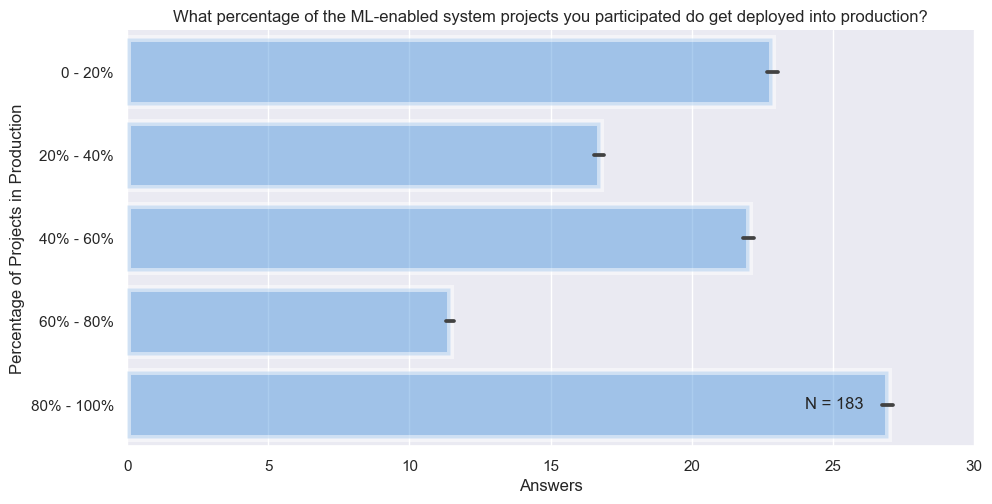

In [36]:
# compute total of answer considered in this question
total_answers = "N = " + str(len(projects_in_production))
total_answers_int = len(projects_in_production)

d7_d8_plot.single_barplot(x_axis="Answers", y_axis="Percentage of Projects in Production",
                       title="What percentage of the ML-enabled system projects you participated do get deployed into production?",
                       x_label="Answers", y_label="Percentage of Projects in Production", x_label_rotation=0, color="#429bf5", total_answers=total_answers)

### Bootstrapping Analysis

In [21]:
valid_options_list = list(production_ranges.keys())

In [22]:
valid_answers_list_temp = projects_in_production

In [23]:
valid_answers_list = []
for valid_answer in valid_answers_list_temp:
    for production_range in production_ranges:
        if (valid_answer >= production_ranges[production_range]['lower_bound']) and (valid_answer < production_ranges[production_range]['upper_bound']):
            valid_answers_list.append(production_range)
            break

In [24]:
replacements =  total_answers_int # equals n - total valid answers
population_sample_size = 1000

bootstrapping_obj = BootstrappingUtils(valid_answers_list, valid_options_list, replacements, population_sample_size, 95)

In [25]:
bootstrapped_dict_data = bootstrapping_obj.bootstrapping('single')

In [27]:
# get a pair of values between dict key and all the list values inside that key 
# key: [val_1, val_2] ---> [(key, val_1), (key, val_2)...]
indexes = []
values = []
chart_positions = []
for idx in bootstrapped_dict_data:
    indexes += [idx for _ in range(len(bootstrapped_dict_data[idx]['population']))]
    values += bootstrapped_dict_data[idx]['population']
    chart_positions += [production_ranges[idx]['position'] for _ in range(len(bootstrapped_dict_data[idx]['population']))]

In [28]:
values = [100 * v for v in values]

In [37]:
# plot object for bootstrapped data
d7_d8_boot_plot = PlotUtils(pd.DataFrame(
    data={'Projects in Production': indexes, 'Value': values, 'Chart Position': chart_positions}
).sort_values(by=['Chart Position'], ascending=False))

C:\Users\Antonio Pedro Alves\.virtualenvs\pfp-antonio-pedro-lcinjCty\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


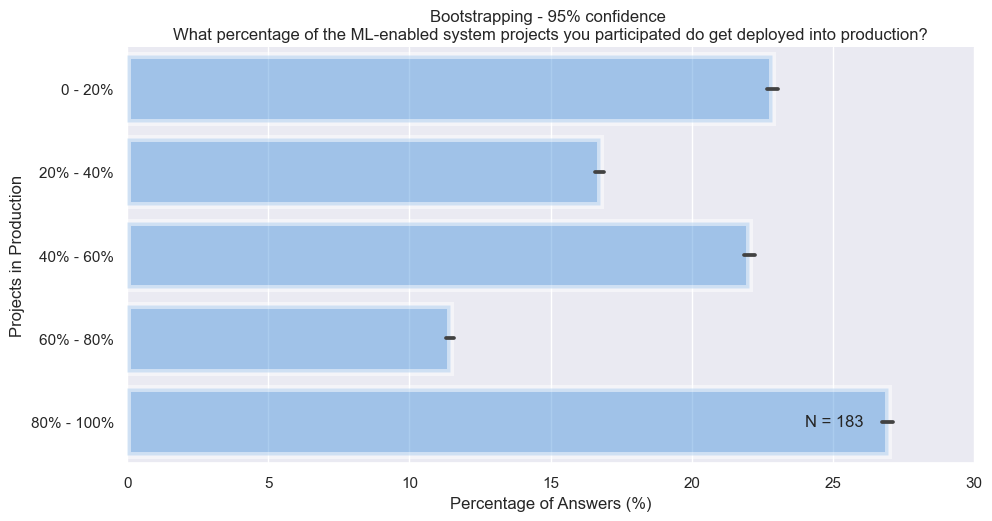

In [38]:
d7_d8_boot_plot.single_barplot(x_axis="Value", y_axis="Projects in Production", 
                       title="Bootstrapping - 95% confidence \nWhat percentage of the ML-enabled system projects you participated do get deployed into production?",
                       x_label="Percentage of Answers (%)", y_label="Projects in Production", x_label_rotation=0, color="#429bf5", 
                       total_answers=total_answers)

In [39]:
# confidence for each option
print("Option: (Lower Value, Mean, Upper Value)")
for idx in bootstrapped_dict_data:
    print(idx + ':' + str(bootstrapped_dict_data[idx]['confidence']))

Option: (Lower Value, Mean, Upper Value)
0 - 20%:(0.22668332440305294, 0.22858469945355192, 0.2304860745040509)
20% - 40%:(0.16563964472175496, 0.16734972677595628, 0.1690598088301576)
40% - 60%:(0.21840375992925976, 0.22037158469945353, 0.2223394094696473)
60% - 80%:(0.11288038945040982, 0.11433333333333331, 0.11578627721625681)
80% - 100%:(0.26733249632216044, 0.26936065573770485, 0.27138881515324925)


In [40]:
# confidence for each option
print("Option: (Lower Value, Mean, Upper Value)")
for idx in bootstrapped_dict_data:
    print(idx + ':: P = ' + str(round((bootstrapped_dict_data[idx]['confidence'][1] * 100), 3)) + " [" + str(round((bootstrapped_dict_data[idx]['confidence'][0] * 100), 3)) + ", " + str(round((bootstrapped_dict_data[idx]['confidence'][2] * 100), 3)) + "]")

Option: (Lower Value, Mean, Upper Value)
0 - 20%:: P = 22.858 [22.668, 23.049]
20% - 40%:: P = 16.735 [16.564, 16.906]
40% - 60%:: P = 22.037 [21.84, 22.234]
60% - 80%:: P = 11.433 [11.288, 11.579]
80% - 100%:: P = 26.936 [26.733, 27.139]
